In [132]:
import pandas as pd
import numpy as np
import pickle
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [127]:
# Load full Data
df_full = pd.read_csv('data/processed/SimpleNNData.csv', index_col=0)
y = np.log(df_full.time_to_reservation)
df_full.drop(columns=['time_to_reservation'], inplace=True)
weather_var = list(df_full.columns[-22:-1])

# Function for scores
def score_model(model, X_train, X_test, y_train, y_test):
    print(f'R2 of training: {r2_score(y_train,model.predict(X_train))}')
    print(f'R2 of test: {r2_score(y_test,model.predict(X_test))}')

    fig, ax = plt.subplots(figsize = (16,10))

    ax.scatter(y_test,model.predict(X_test))
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    plt.show()

In [128]:
def getPipe(model, numerical_columns):
    """
    Prepares a pipe that 
        First:  Prepare the data prior to modelling. That is all numerical features 
                is standardized, all categotical are one.hot-encodeded. The features
                not specified as numerical or categorical are dropped if not specified.
        Second: Send the prepared data into the model.

    """
    # Pipeline to handle continous parameters. Here the parameters are scaled.
    # This is important to do each time so test data is not considered for 
    # normalization which would be the case if all data were standardized at once.
    numeric_transformer = Pipeline([
        ('scale', StandardScaler())
    ])
    
    # Split the data into continous and caterigorical using ColumnTransformer
    # and apply numeric_transformer and categorical_transformer 
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_columns)
        ],
        remainder='passthrough'
    )
    
    # Build the final pipeline for model fitting
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipe

def cv(pipe, parameters, X_train, y_train, cf = 5):    
    """
    Performs paramter tunning using cross-validation on a specifed pipe object.
    """
    # perform cross validaiton over the input parameters
    cv_select = GridSearchCV(
        estimator=pipe, 
        param_grid=parameters, 
        scoring='neg_mean_squared_error', # Use MSE
        n_jobs=-1,
        return_train_score=True,
        verbose=10, 
        cv=cf
    )
    cv_select.fit(X_train, y_train)
    
    return(cv_select)

## No zone and only local info

In [159]:
df = df_full.drop(columns=['index', 'hour_index', 'degree', 'dist_to_station']+weather_var, inplace = False)
df.drop(columns = df.filter(regex = 'lz'), inplace = True)
df

,leave_fuel,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1
0,30,0,1.000000,0.000364,0,0,1,0
1,86,0,0.999999,0.001018,0,0,1,0
2,4,0,0.999997,0.002327,1,0,0,0
3,30,0,0.999968,0.007999,0,0,1,0
4,32,0,0.999957,0.009236,0,1,0,0
...,...,...,...,...,...,...,...,...
326587,94,0,0.999934,-0.011490,0,0,1,0
326588,59,0,0.999970,-0.007708,1,0,0,0
326589,48,0,0.999980,-0.006327,1,0,0,0
326590,23,0,0.999990,-0.004363,0,0,1,0


In [160]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [124]:
LM_model = LinearRegression(fit_intercept = True)
numerical_columns = ['leave_fuel']

parameters = {}

LM_pipe = getPipe(
    model = LM_model,
    numerical_columns = numerical_columns,
)
LM_cv = cv(LM_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................
[CV 2/5; 1/1] START ............................................................
[CV 1/5; 1/1] END ........, score=(train=-2.587, test=-2.614) total time=   0.1s
[CV 2/5; 1/1] END ........, score=(train=-2.590, test=-2.604) total time=   0.1s
[CV 3/5; 1/1] START ............................................................
[CV 4/5; 1/1] START ............................................................
[CV 3/5; 1/1] END ........, score=(train=-2.599, test=-2.568) total time=   0.1s
[CV 5/5; 1/1] START ............................................................
[CV 4/5; 1/1] END ........, score=(train=-2.589, test=-2.606) total time=   0.1s
[CV 5/5; 1/1] END ........, score=(train=-2.598, test=-2.572) total time=   0.1s


R2 of training: 0.09414904773923816
R2 of test: 0.09613254705246155


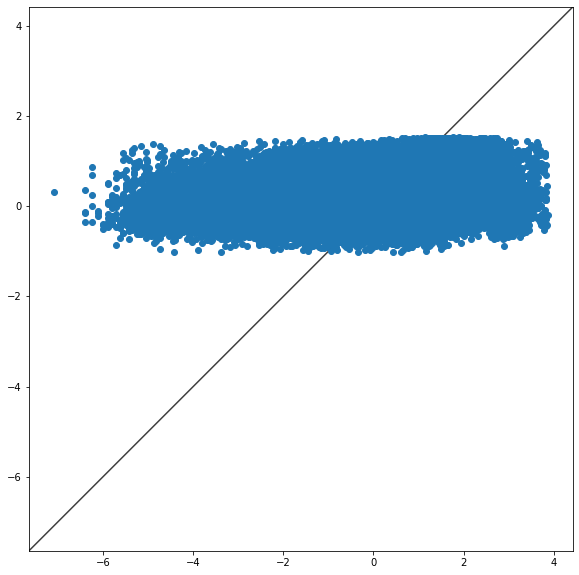

In [125]:
score_model(LM_cv, X_train, X_test, y_train, y_test)

In [108]:
elastic_net_model = ElasticNet(fit_intercept = True)
numerical_columns = ['leave_fuel']

parameters = {
    'model__alpha': np.linspace(0.01, 0.2, 10),
    'model__l1_ratio': np.linspace(0.01, 0.2, 5)
}

elastic_net_pipe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
)
elastic_net_cv = cv(elastic_net_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 2/5; 1/50] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 3/5; 1/50] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 2/5; 1/50] END model__alpha=0.01, model__l1_ratio=0.01;, score=(train=-2.590, test=-2.604) total time=   0.2s
[CV 4/5; 1/50] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 1/5; 1/50] END model__alpha=0.01, model__l1_ratio=0.01;, score=(train=-2.588, test=-2.614) total time=   0.4s
[CV 5/5; 1/50] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 1/5; 2/50] START model__alpha=0.01, model__l1_ratio=0.0575..................
[CV 2/5; 2/50] START model__alpha=0.01, model__l1_ratio=0.0575..................
[CV 3/5; 2/50] START model__alpha=0.01, model__l1_ratio=0.0575..................
[CV 3/5; 1/50] END model__alpha=0.01, model__l1_ratio=0.01;, s

alpha = 0.01, l1-ratio: 0.01
R2 of training: 0.09403243649595239
R2 of test: 0.09604271514055751


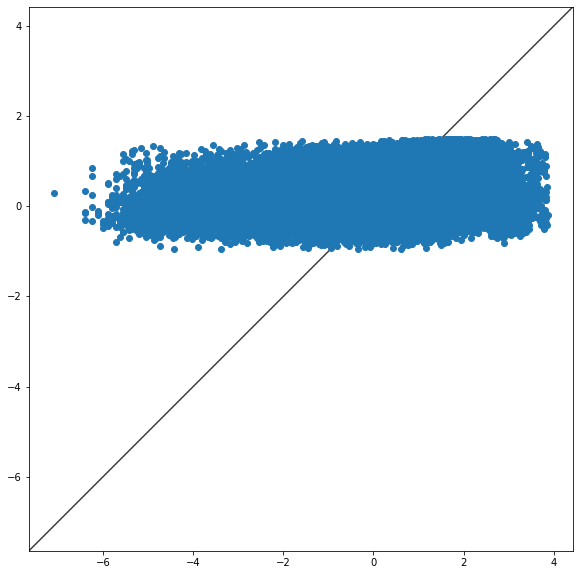

In [112]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f'alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

score_model(elastic_net_cv, X_train, X_test, y_train, y_test)

In [122]:
Ridge_model = Ridge(fit_intercept = True)
numerical_columns = ['leave_fuel']

parameters = {
    'model__alpha': np.linspace(0, 50, 100),
}

Ridge_pipe = getPipe(
    model = Ridge_model,
    numerical_columns = numerical_columns,
)
Ridge_cv = cv(Ridge_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START model__alpha=0.0..........................................
[CV 2/5; 1/100] START model__alpha=0.0..........................................
[CV 1/5; 1/100] END model__alpha=0.0;, score=(train=-2.587, test=-2.614) total time=   0.1s
[CV 3/5; 1/100] START model__alpha=0.0..........................................
[CV 2/5; 1/100] END model__alpha=0.0;, score=(train=-2.590, test=-2.604) total time=   0.1s
[CV 3/5; 1/100] END model__alpha=0.0;, score=(train=-2.599, test=-2.568) total time=   0.1s
[CV 4/5; 1/100] START model__alpha=0.0..........................................
[CV 5/5; 1/100] START model__alpha=0.0..........................................
[CV 4/5; 1/100] END model__alpha=0.0;, score=(train=-2.589, test=-2.606) total time=   0.1s
[CV 1/5; 2/100] START model__alpha=0.5050505050505051...........................
[CV 5/5; 1/100] END model__alpha=0.0;, score=(train=-2.598, test=-2.572) total time

alpha = 18.182
R2 of training: 0.09414904130737756
R2 of test: 0.09613267973854911


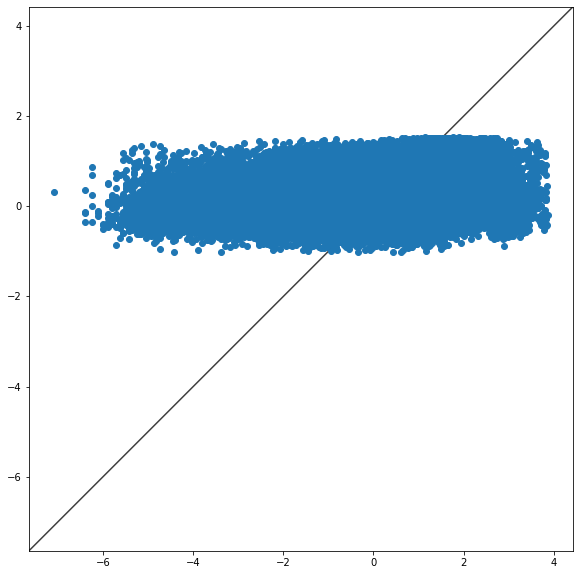

In [123]:
best_idx = Ridge_cv.cv_results_['mean_test_score'].argmax()
alpha = Ridge_cv.cv_results_['param_model__alpha'].data[best_idx]

print(f'alpha = {round(alpha, 3)}')

score_model(Ridge_cv, X_train, X_test, y_train, y_test)

In [131]:
RF_model = RandomForestRegressor()
numerical_columns = ['leave_fuel']

parameters = {
    'model__n_estimators': [50,100,200],
    'model__min_samples_leaf': [5,10,20],
    'model__max_depth': [5,7,10]
}

RF_pipe = getPipe(
    model = RF_model,
    numerical_columns = numerical_columns,
)
RF_cv = cv(RF_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 2/5; 1/9] START model__min_samples_leaf=5, model__n_estimators=50...........
[CV 1/5; 2/9] START model__min_samples_leaf=5, model__n_estimators=100..........
[CV 1/5; 1/9] START model__min_samples_leaf=5, model__n_estimators=50...........
[CV 4/5; 1/9] START model__min_samples_leaf=5, model__n_estimators=50...........
[CV 3/5; 1/9] START model__min_samples_leaf=5, model__n_estimators=50...........
[CV 2/5; 2/9] START model__min_samples_leaf=5, model__n_estimators=100..........
[CV 5/5; 1/9] START model__min_samples_leaf=5, model__n_estimators=50...........
[CV 3/5; 2/9] START model__min_samples_leaf=5, model__n_estimators=100..........
[CV 3/5; 1/9] END model__min_samples_leaf=5, model__n_estimators=50;, score=(train=-1.614, test=-2.670) total time= 2.0min
[CV 4/5; 2/9] START model__min_samples_leaf=5, model__n_estimators=100..........
[CV 2/5; 1/9] END model__min_samples_leaf=5, model__n_estimators=50;, score=(train=-1.60

n_estimators = 200 min_samples_leaf = 20
R2 of training: 0.23024704774176186
R2 of test: 0.10902135576841465


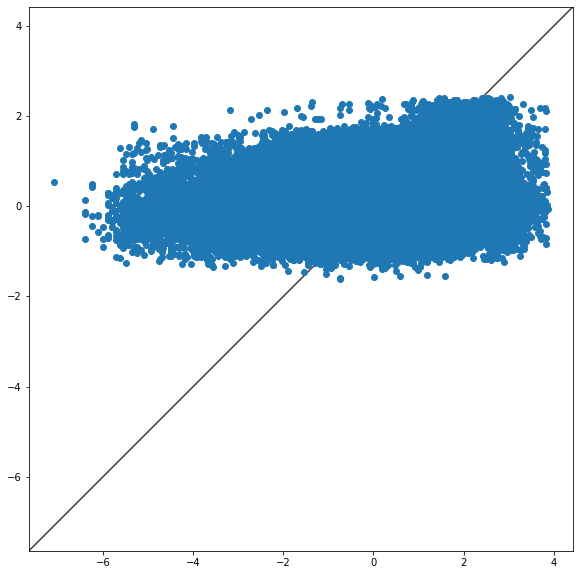

In [141]:
best_idx = RF_cv.cv_results_['mean_test_score'].argmax()
n_estimators = RF_cv.cv_results_['param_model__n_estimators'].data[best_idx]
min_samples_leaf = RF_cv.cv_results_['param_model__min_samples_leaf'].data[best_idx]
#max_depth = RF_cv.cv_results_['param_model__max_depth'].data[best_idx]

print(f'n_estimators = {n_estimators}', f'min_samples_leaf = {min_samples_leaf}')#, f'max_depth = {max_depth}')

score_model(RF_cv, X_train, X_test, y_train, y_test)

In [161]:
KNN_model = KNeighborsRegressor()
numerical_columns = ['leave_fuel']

parameters = {
    'model__n_neighbors': [50,100,150],
    'model__weights': ['uniform', 'distance']
}

KNN_pipe = getPipe(
    model = KNN_model,
    numerical_columns = numerical_columns,
)
KNN_cv = cv(KNN_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 2/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 3/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 4/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 5/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 1/5; 2/6] START model__n_neighbors=50, model__weights=distance..............
[CV 2/5; 2/6] START model__n_neighbors=50, model__weights=distance..............
[CV 3/5; 2/6] START model__n_neighbors=50, model__weights=distance..............
[CV 1/5; 1/6] END model__n_neighbors=50, model__weights=uniform;, score=(train=-2.439, test=-2.541) total time=  14.1s
[CV 4/5; 2/6] START model__n_neighbors=50, model__weights=distance..............
[CV 1/5; 2/6] END model__n_neighbors=50, model__weights=distance;, score=(train=-0.016, test

n_neighbors = 150 weights = uniform
R2 of training: 0.13310805667403425
R2 of test: 0.11775070494416817


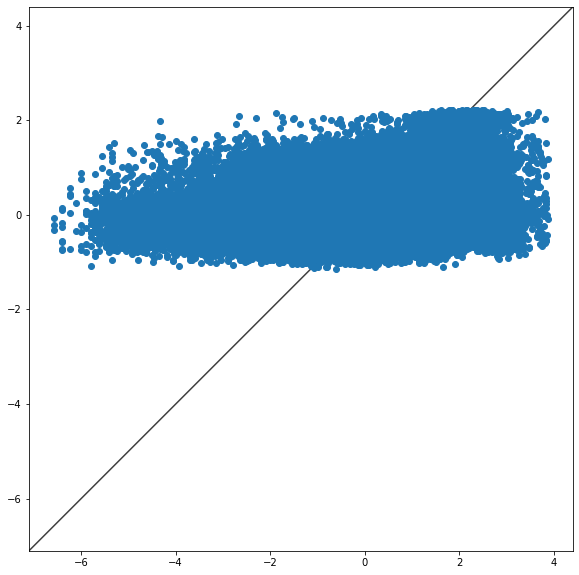

In [162]:
best_idx = KNN_cv.cv_results_['mean_test_score'].argmax()
n_neighbors = KNN_cv.cv_results_['param_model__n_neighbors'].data[best_idx]
weights = KNN_cv.cv_results_['param_model__weights'].data[best_idx]

print(f'n_neighbors = {n_neighbors}', f'weights = {weights}')

score_model(KNN_cv, X_train, X_test, y_train, y_test)

## Add non-local info

In [267]:
df = df_full.drop(columns=['index', 'hour_index']+weather_var, inplace = False)
df.drop(columns = df.filter(regex = 'lz'), inplace = True)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,dist_to_station
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,386.856080
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,1096.295483
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,812.660741
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,897.592806
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,599.103807
...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,275.431500
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,546.398658
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,615.556913
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,495.570805


In [268]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [269]:
LM_model = LinearRegression(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station']

parameters = {}

LM_pipe = getPipe(
    model = LM_model,
    numerical_columns = numerical_columns,
)
LM_cv = cv(LM_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5; 1/1] START ............................................................
[CV 5/5; 1/1] START ............................................................
[CV 1/5; 1/1] START ............................................................
[CV 3/5; 1/1] START ............................................................
[CV 4/5; 1/1] START ............................................................
[CV 5/5; 1/1] END ........, score=(train=-2.480, test=-2.488) total time=   0.2s
[CV 1/5; 1/1] END ........, score=(train=-2.487, test=-2.460) total time=   0.2s
[CV 3/5; 1/1] END ........, score=(train=-2.472, test=-2.521) total time=   0.2s
[CV 4/5; 1/1] END ........, score=(train=-2.486, test=-2.466) total time=   0.2s
[CV 2/5; 1/1] END ........, score=(train=-2.483, test=-2.475) total time=   0.2s


R2 of training: 0.133497015403792
R2 of test: 0.1337733389418193


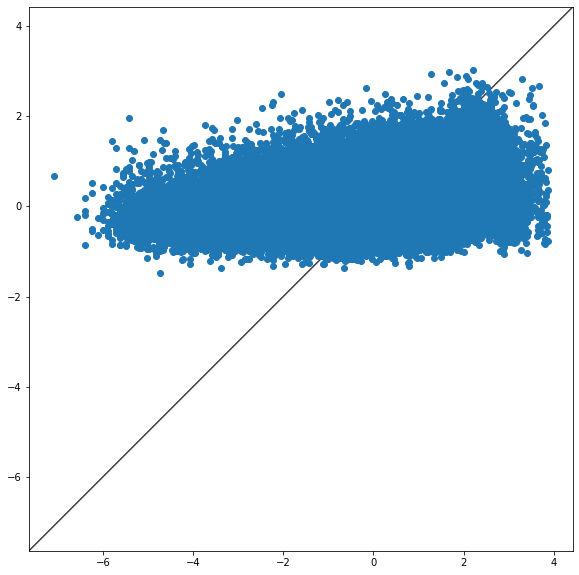

In [270]:
score_model(LM_cv, X_train, X_test, y_train, y_test)

In [271]:
elastic_net_model = ElasticNet(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station']

parameters = {
    'model__alpha': np.linspace(0.01, 1, 10),
    'model__l1_ratio': np.linspace(0.01, 0.2, 5)
}

elastic_net_pipe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
)
elastic_net_cv = cv(elastic_net_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 2/5; 1/50] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 3/5; 1/50] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 4/5; 1/50] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 1/5; 2/50] START model__alpha=0.01, model__l1_ratio=0.0575..................
[CV 2/5; 2/50] START model__alpha=0.01, model__l1_ratio=0.0575..................
[CV 2/5; 1/50] END model__alpha=0.01, model__l1_ratio=0.01;, score=(train=-2.484, test=-2.475) total time=   0.6s
[CV 3/5; 1/50] END model__alpha=0.01, model__l1_ratio=0.01;, score=(train=-2.472, test=-2.521) total time=   0.8s
[CV 4/5; 1/50] END model__alpha=0.01, model__l1_ratio=0.01;, score=(train=-2.486, test=-2.466) total time=   0.7s
[CV 4/5; 2/50] START model__alpha=0.01, model__l1_ratio=0.0575..................
[CV 2/5; 2/50] END model__alpha=0.01, model__l1_ratio=0.0575;, score=(train=-2.484, test=-2.475) total time=  

alpha = 0.01, l1-ratio: 0.01
R2 of training: 0.1333875762063631
R2 of test: 0.13371765262123525


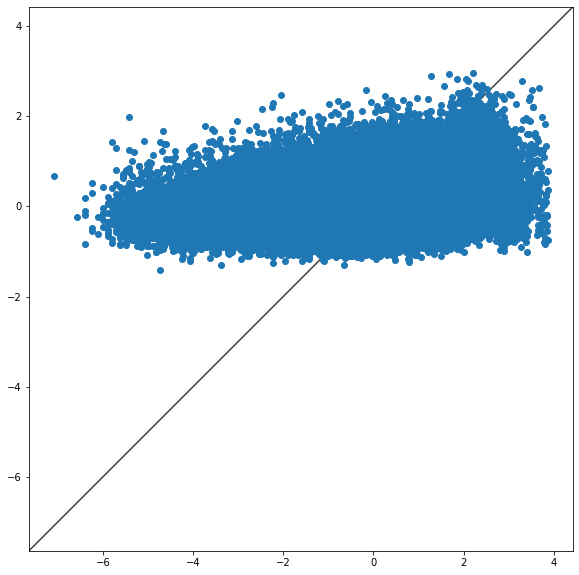

In [272]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f'alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

score_model(elastic_net_cv, X_train, X_test, y_train, y_test)

In [273]:
Ridge_model = Ridge(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station']

parameters = {
    'model__alpha': np.linspace(0, 50, 100),
}

Ridge_pipe = getPipe(
    model = Ridge_model,
    numerical_columns = numerical_columns,
)
Ridge_cv = cv(Ridge_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START model__alpha=0.0..........................................
[CV 2/5; 1/100] START model__alpha=0.0..........................................
[CV 1/5; 1/100] END model__alpha=0.0;, score=(train=-2.487, test=-2.460) total time=   0.1s
[CV 3/5; 1/100] START model__alpha=0.0..........................................


/opt/anaconda3/envs/GNN_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.50202e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/envs/GNN_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.11176e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[CV 2/5; 1/100] END model__alpha=0.0;, score=(train=-2.483, test=-2.475) total time=   0.1s
[CV 4/5; 1/100] START model__alpha=0.0..........................................
[CV 3/5; 1/100] END model__alpha=0.0;, score=(train=-2.472, test=-2.521) total time=   0.2s
[CV 4/5; 1/100] END model__alpha=0.0;, score=(train=-2.486, test=-2.466) total time=   0.1s
[CV 5/5; 1/100] START model__alpha=0.0..........................................
[CV 1/5; 2/100] START model__alpha=0.5050505050505051...........................
[CV 5/5; 1/100] END model__alpha=0.0;, score=(train=-2.480, test=-2.488) total time=   0.1s
[CV 2/5; 2/100] START model__alpha=0.5050505050505051...........................
[CV 1/5; 2/100] END model__alpha=0.5050505050505051;, score=(train=-2.487, test=-2.460) total time=   0.1s
[CV 3/5; 2/100] START model__alpha=0.5050505050505051...........................
[CV 2/5; 2/100] END model__alpha=0.5050505050505051;, score=(train=-2.483, test=-2.475) total time=   0.1s
[CV 4/5; 2/10

alpha = 24.242
R2 of training: 0.1334970046838333
R2 of test: 0.1337738901068266


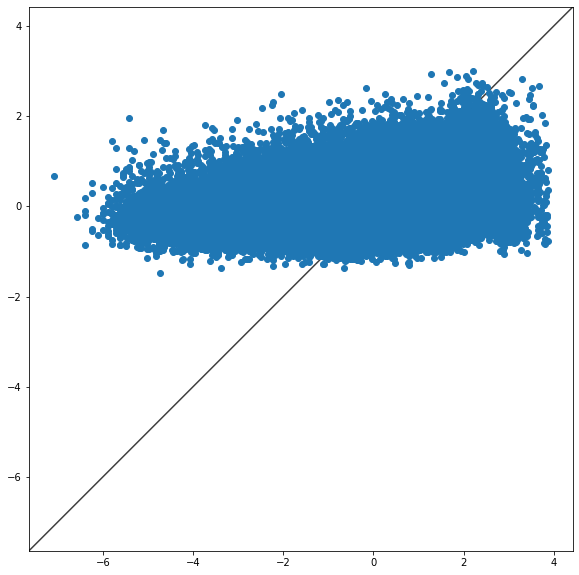

In [274]:
best_idx = Ridge_cv.cv_results_['mean_test_score'].argmax()
alpha = Ridge_cv.cv_results_['param_model__alpha'].data[best_idx]

print(f'alpha = {round(alpha, 3)}')

score_model(Ridge_cv, X_train, X_test, y_train, y_test)

In [275]:
KNN_model = KNeighborsRegressor()
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station']

parameters = {
    'model__n_neighbors': [50,100,150],
    'model__weights': ['uniform', 'distance']
}

KNN_pipe = getPipe(
    model = KNN_model,
    numerical_columns = numerical_columns,
)
KNN_cv = cv(KNN_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 2/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 1/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 5/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 2/5; 2/6] START model__n_neighbors=50, model__weights=distance..............
[CV 4/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............
[CV 1/5; 2/6] START model__n_neighbors=50, model__weights=distance..............[CV 3/5; 1/6] START model__n_neighbors=50, model__weights=uniform...............

[CV 3/5; 2/6] START model__n_neighbors=50, model__weights=distance..............
[CV 4/5; 1/6] END model__n_neighbors=50, model__weights=uniform;, score=(train=-2.303, test=-2.382) total time=  30.7s
[CV 4/5; 2/6] START model__n_neighbors=50, model__weights=distance..............
[CV 5/5; 1/6] END model__n_neighbors=50, model__weights=uniform;, score=(train=-2.300, test=

n_neighbors = 150 weights = distance
R2 of training: 1.0
R2 of test: 0.16963059273335712


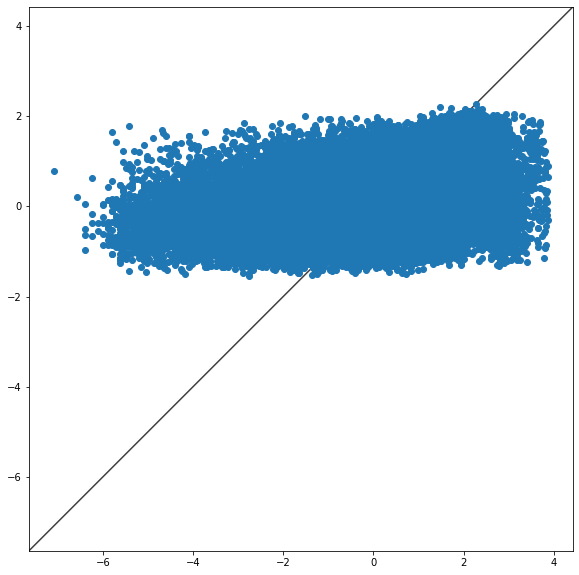

In [276]:
best_idx = KNN_cv.cv_results_['mean_test_score'].argmax()
n_neighbors = KNN_cv.cv_results_['param_model__n_neighbors'].data[best_idx]
weights = KNN_cv.cv_results_['param_model__weights'].data[best_idx]
 
print(f'n_neighbors = {n_neighbors}', f'weights = {weights}')

score_model(KNN_cv, X_train, X_test, y_train, y_test)

## Add weather

In [277]:
df = df_full.drop(columns=['index', 'hour_index']+weather_var[7:], inplace = False)
df.drop(columns = df.filter(regex = 'lz'), inplace = True)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,386.856080
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,1096.295483
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,812.660741
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,897.592806
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,275.431500
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,546.398658
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,615.556913
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,495.570805


In [278]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [279]:
LM_model = LinearRegression(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station']+weather_var[:7]

parameters = {}

LM_pipe = getPipe(
    model = LM_model,
    numerical_columns = numerical_columns,
)
LM_cv = cv(LM_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................
[CV 2/5; 1/1] START ............................................................
[CV 3/5; 1/1] START ............................................................
[CV 1/5; 1/1] END ........, score=(train=-2.474, test=-2.462) total time=   0.3s
[CV 4/5; 1/1] START ............................................................
[CV 2/5; 1/1] END ........, score=(train=-2.466, test=-2.493) total time=   0.3s
[CV 5/5; 1/1] START ............................................................
[CV 3/5; 1/1] END ........, score=(train=-2.475, test=-2.458) total time=   0.3s
[CV 4/5; 1/1] END ........, score=(train=-2.476, test=-2.454) total time=   0.3s
[CV 5/5; 1/1] END ........, score=(train=-2.466, test=-2.491) total time=   0.3s


R2 of training: 0.13583685962035064
R2 of test: 0.13551191266276164


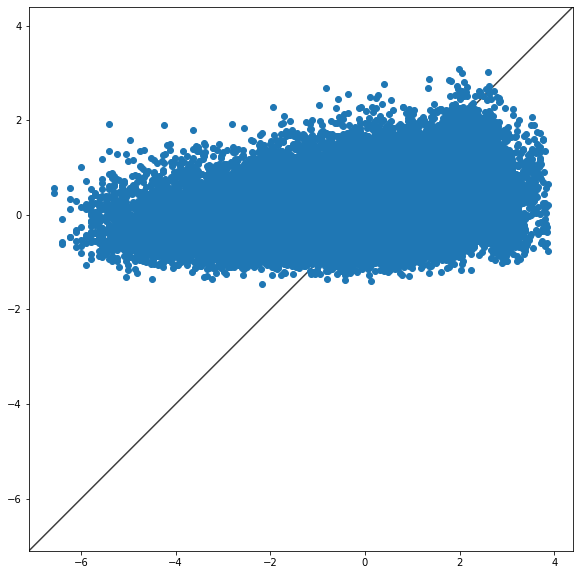

In [280]:
score_model(LM_cv, X_train, X_test, y_train, y_test)

In [281]:
elastic_net_model = ElasticNet(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station']+weather_var[:7]

parameters = {
    'model__alpha': np.linspace(0.01, 1, 10),
    'model__l1_ratio': np.linspace(0.01, 0.2, 5)
}

elastic_net_pipe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
)
elastic_net_cv = cv(elastic_net_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 2/5; 1/50] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 3/5; 1/50] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 5/5; 1/50] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 2/5; 2/50] START model__alpha=0.01, model__l1_ratio=0.0575..................
[CV 3/5; 2/50] START model__alpha=0.01, model__l1_ratio=0.0575..................
[CV 1/5; 1/50] END model__alpha=0.01, model__l1_ratio=0.01;, score=(train=-2.474, test=-2.462) total time=   0.5s
[CV 4/5; 2/50] START model__alpha=0.01, model__l1_ratio=0.0575..................
[CV 2/5; 1/50] END model__alpha=0.01, model__l1_ratio=0.01;, score=(train=-2.466, test=-2.494) total time=   0.7s
[CV 5/5; 2/50] START model__alpha=0.01, model__l1_ratio=0.0575..................
[CV 3/5; 1/50] END model__alpha=0.01, model__l1_ratio=0.01;, s

alpha = 0.01, l1-ratio: 0.01
R2 of training: 0.13571233233530045
R2 of test: 0.13539576992131952


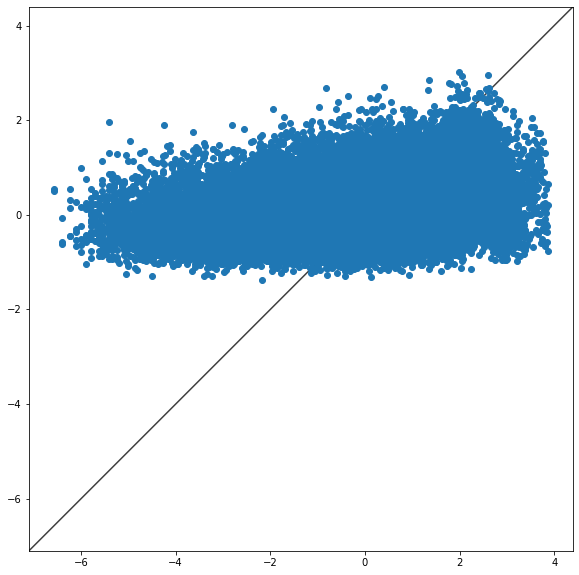

In [282]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f'alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

score_model(elastic_net_cv, X_train, X_test, y_train, y_test)

In [283]:
Ridge_model = Ridge(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station']+weather_var[:7]

parameters = {
    'model__alpha': np.linspace(0, 50, 100),
}

Ridge_pipe = getPipe(
    model = Ridge_model,
    numerical_columns = numerical_columns,
)
Ridge_cv = cv(Ridge_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START model__alpha=0.0..........................................
[CV 2/5; 1/100] START model__alpha=0.0..........................................
[CV 3/5; 1/100] START model__alpha=0.0..........................................


/opt/anaconda3/envs/GNN_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.46035e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/envs/GNN_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.9119e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[CV 4/5; 1/100] START model__alpha=0.0..........................................
[CV 2/5; 1/100] END model__alpha=0.0;, score=(train=-2.466, test=-2.493) total time=   0.2s
[CV 3/5; 1/100] END model__alpha=0.0;, score=(train=-2.475, test=-2.458) total time=   0.2s
[CV 1/5; 1/100] END model__alpha=0.0;, score=(train=-2.474, test=-2.462) total time=   0.4s
[CV 5/5; 1/100] START model__alpha=0.0..........................................


/opt/anaconda3/envs/GNN_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.63235e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[CV 4/5; 1/100] END model__alpha=0.0;, score=(train=-2.476, test=-2.454) total time=   0.2s
[CV 1/5; 2/100] START model__alpha=0.5050505050505051...........................
[CV 2/5; 2/100] START model__alpha=0.5050505050505051...........................
[CV 3/5; 2/100] START model__alpha=0.5050505050505051...........................
[CV 1/5; 2/100] END model__alpha=0.5050505050505051;, score=(train=-2.474, test=-2.462) total time=   0.2s
[CV 4/5; 2/100] START model__alpha=0.5050505050505051...........................
[CV 5/5; 1/100] END model__alpha=0.0;, score=(train=-2.467, test=-2.491) total time=   0.3s
[CV 2/5; 2/100] END model__alpha=0.5050505050505051;, score=(train=-2.466, test=-2.493) total time=   0.2s
[CV 5/5; 2/100] START model__alpha=0.5050505050505051...........................
[CV 3/5; 2/100] END model__alpha=0.5050505050505051;, score=(train=-2.475, test=-2.458) total time=   0.2s
[CV 1/5; 3/100] START model__alpha=1.0101010101010102...........................
[CV 4/5; 

alpha = 0.0
R2 of training: 0.13582063967729763
R2 of test: 0.13551422536748514


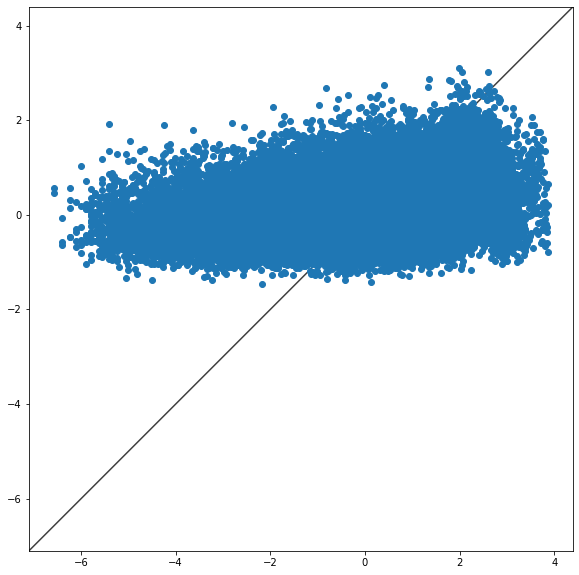

In [284]:
best_idx = Ridge_cv.cv_results_['mean_test_score'].argmax()
alpha = Ridge_cv.cv_results_['param_model__alpha'].data[best_idx]

print(f'alpha = {round(alpha, 3)}')

score_model(Ridge_cv, X_train, X_test, y_train, y_test)

In [286]:
KNN_model = KNeighborsRegressor()
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station']+weather_var[:7]

parameters = {}
#    'model__n_neighbors': [50,100,150],
#    'model__weights': ['uniform', 'distance']
#}

KNN_pipe = getPipe(
    model = KNN_model,
    numerical_columns = numerical_columns,
)
KNN_cv = cv(KNN_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5; 1/1] START ............................................................
[CV 4/5; 1/1] START ............................................................
[CV 2/5; 1/1] START ............................................................
[CV 1/5; 1/1] START ............................................................
[CV 3/5; 1/1] START ............................................................
[CV 5/5; 1/1] END ........, score=(train=-1.845, test=-2.816) total time= 6.0min
[CV 2/5; 1/1] END ........, score=(train=-1.853, test=-2.792) total time= 6.4min
[CV 1/5; 1/1] END ........, score=(train=-1.856, test=-2.756) total time= 6.3min
[CV 4/5; 1/1] END ........, score=(train=-1.855, test=-2.772) total time= 6.5min
[CV 3/5; 1/1] END ........, score=(train=-1.858, test=-2.775) total time= 6.5min


In [288]:
best_idx = KNN_cv.cv_results_['mean_test_score'].argmax()
#n_neighbors = KNN_cv.cv_results_['param_model__n_neighbors'].data[best_idx]
#weights = KNN_cv.cv_results_['param_model__weights'].data[best_idx]

#print(f'n_neighbors = {n_neighbors}', f'weights = {weights}')

score_model(KNN_cv, X_train, X_test, y_train, y_test)

KeyboardInterrupt: 

In [289]:
print(f'R2 of test: {r2_score(y_test,KNN_cv.predict(X_test))}')

R2 of test: 0.026559600183948207


## Add zone

In [290]:
df = df_full.drop(columns=['index', 'hour_index']+weather_var[7:], inplace = False)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185154,lz_185203,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,386.856080
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,1096.295483
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,812.660741
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,897.592806
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,275.431500
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,546.398658
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,615.556913
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,495.570805


In [291]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [292]:
LM_model = LinearRegression(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station']+weather_var[:7]

parameters = {}

LM_pipe = getPipe(
    model = LM_model,
    numerical_columns = numerical_columns,
)
LM_cv = cv(LM_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5; 1/1] START ............................................................
[CV 1/5; 1/1] START ............................................................
[CV 3/5; 1/1] START ............................................................
[CV 4/5; 1/1] START ............................................................
[CV 5/5; 1/1] START ............................................................
[CV 1/5; 1/1] END ........, score=(train=-2.195, test=-2.182) total time=  26.5s
[CV 3/5; 1/1] END ........, score=(train=-2.195, test=-2.181) total time=  26.5s
[CV 2/5; 1/1] END ........, score=(train=-2.187, test=-2.212) total time=  26.5s
[CV 4/5; 1/1] END ........, score=(train=-2.191, test=-2.197) total time=  26.5s
[CV 5/5; 1/1] END ........, score=(train=-2.188, test=-2.210) total time=  26.5s


R2 of training: 0.23234565546277486
R2 of test: 0.23132892758940338


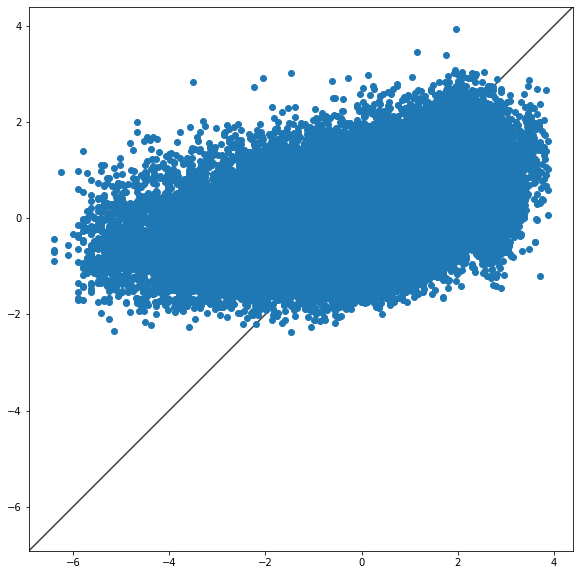

In [293]:
score_model(LM_cv, X_train, X_test, y_train, y_test)

In [294]:
elastic_net_model = ElasticNet(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station']+weather_var[:7]

parameters = {
    'model__alpha': np.linspace(0.01, 1, 5),
    'model__l1_ratio': [0.01,0.1]
}

elastic_net_pipe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
)
elastic_net_cv = cv(elastic_net_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 2/5; 1/10] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 3/5; 1/10] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 4/5; 1/10] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 5/5; 1/10] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 1/5; 2/10] START model__alpha=0.01, model__l1_ratio=0.1.....................
[CV 1/5; 1/10] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 2/5; 2/10] START model__alpha=0.01, model__l1_ratio=0.1.....................
[CV 3/5; 2/10] START model__alpha=0.01, model__l1_ratio=0.1.....................
[CV 1/5; 2/10] END model__alpha=0.01, model__l1_ratio=0.1;, score=(train=-2.365, test=-2.348) total time=  31.8s
[CV 4/5; 2/10] START model__alpha=0.01, model__l1_ratio=0.1.....................
[CV 2/5; 1/10] END model__alpha=0.01, model__l1_ratio=0.01;, score=(train=-2.329, test=-2.343) to

alpha = 0.01, l1-ratio: 0.01
R2 of training: 0.18309484853732483
R2 of test: 0.18436978347974753


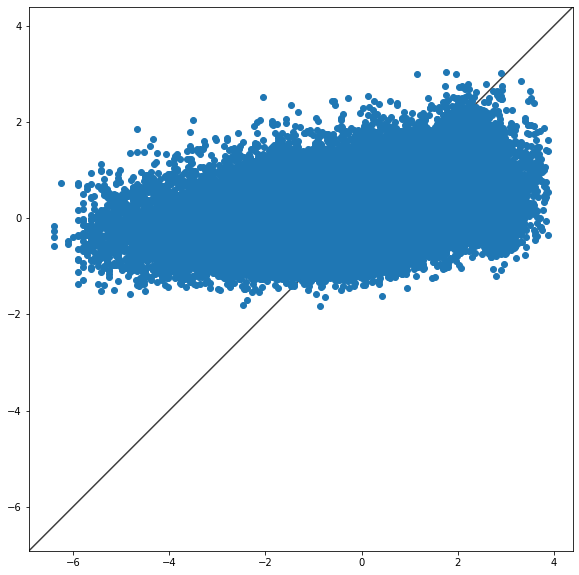

In [295]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f'alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

score_model(elastic_net_cv, X_train, X_test, y_train, y_test)

In [296]:
Ridge_model = Ridge(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station']+weather_var[:7]

parameters = {
    'model__alpha': np.linspace(0, 10, 20),
}

Ridge_pipe = getPipe(
    model = Ridge_model,
    numerical_columns = numerical_columns,
)
Ridge_cv = cv(Ridge_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START model__alpha=0.0...........................................
[CV 2/5; 1/20] START model__alpha=0.0...........................................
[CV 3/5; 1/20] START model__alpha=0.0...........................................
[CV 4/5; 1/20] START model__alpha=0.0...........................................
[CV 5/5; 1/20] START model__alpha=0.0...........................................
[CV 1/5; 2/20] START model__alpha=0.5263157894736842............................
[CV 2/5; 2/20] START model__alpha=0.5263157894736842............................
[CV 3/5; 2/20] START model__alpha=0.5263157894736842............................


/opt/anaconda3/envs/GNN_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.56152e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/envs/GNN_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.30325e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[CV 3/5; 1/20] END model__alpha=0.0;, score=(train=-2.195, test=-2.181) total time=  10.6s
[CV 4/5; 2/20] START model__alpha=0.5263157894736842............................
[CV 2/5; 2/20] END model__alpha=0.5263157894736842;, score=(train=-2.187, test=-2.212) total time=  12.5s
[CV 5/5; 1/20] END model__alpha=0.0;, score=(train=-2.188, test=-2.210) total time=  13.0s
[CV 3/5; 2/20] END model__alpha=0.5263157894736842;, score=(train=-2.195, test=-2.181) total time=  12.7s
[CV 1/5; 2/20] END model__alpha=0.5263157894736842;, score=(train=-2.195, test=-2.182) total time=  13.2s
[CV 5/5; 2/20] START model__alpha=0.5263157894736842............................
[CV 1/5; 3/20] START model__alpha=1.0526315789473684............................
[CV 2/5; 3/20] START model__alpha=1.0526315789473684............................
[CV 3/5; 3/20] START model__alpha=1.0526315789473684............................
[CV 1/5; 1/20] END model__alpha=0.0;, score=(train=-2.195, test=-2.183) total time=  24.0s
[CV 

alpha = 2.105
R2 of training: 0.23234157881856055
R2 of test: 0.23133596614721963


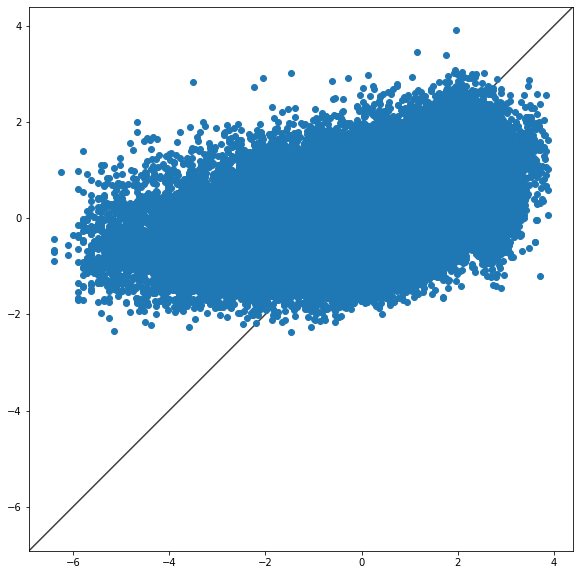

In [297]:
best_idx = Ridge_cv.cv_results_['mean_test_score'].argmax()
alpha = Ridge_cv.cv_results_['param_model__alpha'].data[best_idx]

print(f'alpha = {round(alpha, 3)}')

score_model(Ridge_cv, X_train, X_test, y_train, y_test)

## Encode zones

In [298]:
df = df_full.drop(columns=['index', 'hour_index']+weather_var[7:], inplace = False)
df

,leave_fuel,degree,weekend,Time_Cos,Time_Sin,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,...,lz_185154,lz_185203,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover,dist_to_station
0,30,12.529378,0,1.000000,0.000364,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,386.856080
1,86,14.027280,0,0.999999,0.001018,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,1096.295483
2,4,17.751882,0,0.999997,0.002327,1,0,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,812.660741
3,30,1.806991,0,0.999968,0.007999,0,0,1,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,897.592806
4,32,13.214864,0,0.999957,0.009236,0,1,0,0,0,...,0,0,14.2,1.8,0.0,0.0,1013.8,73.6,17.0,599.103807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326587,94,20.556195,0,0.999934,-0.011490,0,0,1,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,275.431500
326588,59,14.221806,0,0.999970,-0.007708,1,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,546.398658
326589,48,16.451925,0,0.999980,-0.006327,1,0,0,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,615.556913
326590,23,15.140361,0,0.999990,-0.004363,0,0,1,0,0,...,0,0,4.6,2.7,0.0,0.0,1019.7,94.2,50.0,495.570805


In [299]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)

In [300]:
Mean_Zone_Times = dict(pd.DataFrame({'Zone': X_train.filter(regex = 'lz').idxmax(axis = 1).values, 'Time':y_train.values}).groupby('Zone').mean().squeeze())

In [301]:
X_train['Zone_E'] = X_train.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
X_test['Zone_E'] = X_test.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
X_train.drop(columns = X_train.filter(regex = 'lz'), inplace = True)
X_test.drop(columns =  X_test.filter(regex = 'lz'), inplace = True)

/var/folders/3z/pggbcw7949507j0lbw1gjngc0000gn/T/ipykernel_15904/1497919222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Zone_E'] = X_train.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
/var/folders/3z/pggbcw7949507j0lbw1gjngc0000gn/T/ipykernel_15904/1497919222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Zone_E'] = X_test.filter(regex = 'lz').idxmax(1).map(Mean_Zone_Times)
/opt/anaconda3/envs/GNN_env/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopy

In [303]:
LM_model = LinearRegression(fit_intercept = False)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station','Zone_E']+weather_var[:7]

parameters = {}

LM_pipe = getPipe(
    model = LM_model,
    numerical_columns = numerical_columns,
)
LM_cv = cv(LM_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................
[CV 2/5; 1/1] START ............................................................
[CV 3/5; 1/1] START ............................................................
[CV 4/5; 1/1] START ............................................................
[CV 5/5; 1/1] START ............................................................
[CV 1/5; 1/1] END ........, score=(train=-2.248, test=-2.261) total time=   0.3s
[CV 2/5; 1/1] END ........, score=(train=-2.245, test=-2.270) total time=   0.4s
[CV 3/5; 1/1] END ........, score=(train=-2.246, test=-2.267) total time=   0.4s
[CV 5/5; 1/1] END ........, score=(train=-2.257, test=-2.224) total time=   0.4s
[CV 4/5; 1/1] END ........, score=(train=-2.255, test=-2.230) total time=   0.4s


R2 of training: 0.21325768129773803
R2 of test: 0.21727701943265754


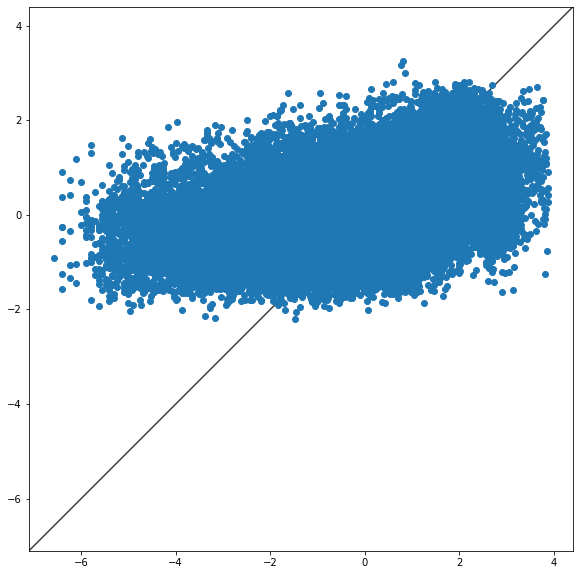

In [304]:
score_model(LM_cv, X_train, X_test, y_train, y_test)

In [309]:
elastic_net_model = ElasticNet(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station','Zone_E']+weather_var[:7]

parameters = {
    'model__alpha': np.linspace(0.01, 1, 5),
    'model__l1_ratio': [0.001, 0.01,0.1]
}

elastic_net_pipe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
)
elastic_net_cv = cv(elastic_net_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5; 1/15] START model__alpha=0.01, model__l1_ratio=0.001...................
[CV 2/5; 1/15] START model__alpha=0.01, model__l1_ratio=0.001...................
[CV 3/5; 1/15] START model__alpha=0.01, model__l1_ratio=0.001...................
[CV 4/5; 1/15] START model__alpha=0.01, model__l1_ratio=0.001...................
[CV 5/5; 1/15] START model__alpha=0.01, model__l1_ratio=0.001...................
[CV 1/5; 2/15] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 2/5; 2/15] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 3/5; 2/15] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 1/5; 1/15] END model__alpha=0.01, model__l1_ratio=0.001;, score=(train=-2.248, test=-2.261) total time=   2.7s
[CV 4/5; 2/15] START model__alpha=0.01, model__l1_ratio=0.01....................
[CV 2/5; 1/15] END model__alpha=0.01, model__l1_ratio=0.001;, score=(train=-2.246, test=-2.270)

alpha = 0.01, l1-ratio: 0.001
R2 of training: 0.21313759506978802
R2 of test: 0.21696570141458094


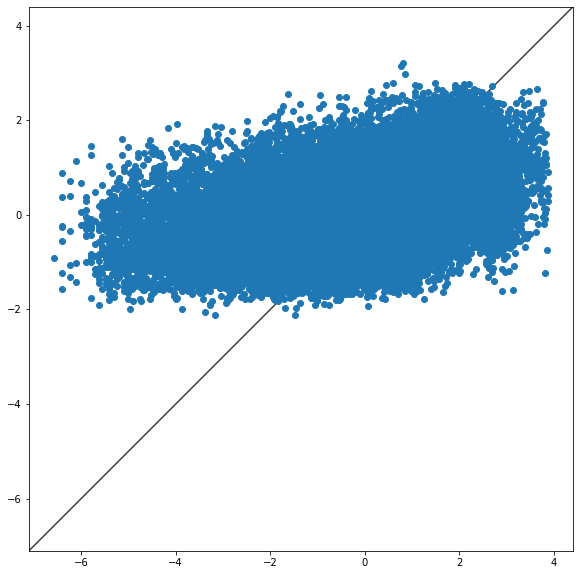

In [310]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f'alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

score_model(elastic_net_cv, X_train, X_test, y_train, y_test)

In [311]:
Ridge_model = Ridge(fit_intercept = True)
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station','Zone_E']+weather_var[:7]

parameters = {
    'model__alpha': np.linspace(0, 10, 50),
}

Ridge_pipe = getPipe(
    model = Ridge_model,
    numerical_columns = numerical_columns,
)
Ridge_cv = cv(Ridge_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START model__alpha=0.0...........................................
[CV 2/5; 1/50] START model__alpha=0.0...........................................
[CV 3/5; 1/50] START model__alpha=0.0...........................................
[CV 4/5; 1/50] START model__alpha=0.0...........................................
[CV 5/5; 1/50] START model__alpha=0.0...........................................
[CV 3/5; 1/50] END model__alpha=0.0;, score=(train=-2.246, test=-2.267) total time=   0.3s
[CV 1/5; 1/50] END model__alpha=0.0;, score=(train=-2.248, test=-2.261) total time=   0.4s
[CV 1/5; 2/50] START model__alpha=0.20408163265306123...........................


/opt/anaconda3/envs/GNN_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.10907e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/opt/anaconda3/envs/GNN_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.46908e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


[CV 2/5; 1/50] END model__alpha=0.0;, score=(train=-2.245, test=-2.270) total time=   0.4s
[CV 2/5; 2/50] START model__alpha=0.20408163265306123...........................
[CV 3/5; 2/50] START model__alpha=0.20408163265306123...........................
[CV 4/5; 1/50] END model__alpha=0.0;, score=(train=-2.255, test=-2.230) total time=   0.3s
[CV 5/5; 1/50] END model__alpha=0.0;, score=(train=-2.257, test=-2.224) total time=   0.3s
[CV 1/5; 2/50] END model__alpha=0.20408163265306123;, score=(train=-2.248, test=-2.261) total time=   0.2s
[CV 4/5; 2/50] START model__alpha=0.20408163265306123...........................
[CV 2/5; 2/50] END model__alpha=0.20408163265306123;, score=(train=-2.245, test=-2.270) total time=   0.2s
[CV 3/5; 2/50] END model__alpha=0.20408163265306123;, score=(train=-2.246, test=-2.267) total time=   0.2s
[CV 5/5; 2/50] START model__alpha=0.20408163265306123...........................
[CV 1/5; 3/50] START model__alpha=0.40816326530612246...........................
[

/opt/anaconda3/envs/GNN_env/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.50923e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


alpha = 0.0
R2 of training: 0.21325768129773803
R2 of test: 0.21727701943265754


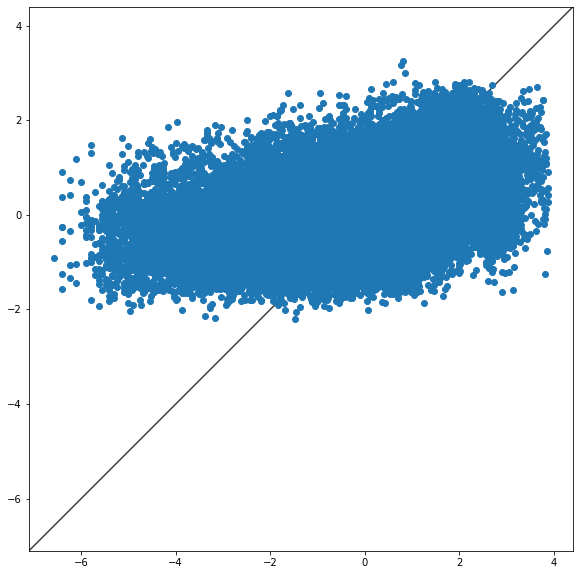

In [312]:
best_idx = Ridge_cv.cv_results_['mean_test_score'].argmax()
alpha = Ridge_cv.cv_results_['param_model__alpha'].data[best_idx]

print(f'alpha = {round(alpha, 3)}')

score_model(Ridge_cv, X_train, X_test, y_train, y_test)

In [314]:
KNN_model = KNeighborsRegressor()
numerical_columns = ['leave_fuel', 'degree', 'dist_to_station','Zone_E']+weather_var[:7]

parameters = {
    'model__n_neighbors': [50,100]
    #'model__weights': ['uniform', 'distance']
}

KNN_pipe = getPipe(
    model = KNN_model,
    numerical_columns = numerical_columns,
)
KNN_cv = cv(KNN_pipe, parameters, X_train, y_train, cf = 5)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 4/5; 1/2] START model__n_neighbors=50.......................................
[CV 2/5; 1/2] START model__n_neighbors=50.......................................
[CV 3/5; 2/2] START model__n_neighbors=100......................................
[CV 3/5; 1/2] START model__n_neighbors=50.......................................
[CV 2/5; 2/2] START model__n_neighbors=100......................................
[CV 5/5; 1/2] START model__n_neighbors=50.......................................
[CV 1/5; 2/2] START model__n_neighbors=100......................................
[CV 1/5; 1/2] START model__n_neighbors=50.......................................


KeyboardInterrupt: 